# Melanoma Detection Assignment

Melanoma is the most serious type of skin cancer. It occurs when the pigment-producing cells that give colour to the skin become cancerous. Symptoms might include a new, unusual growth or a change in an existing mole. Melanomas can occur anywhere on the body. Though it is very fatal, it is curable in most cases if its detected in its early stages. Therefore having an automated, reliable, scalable system which can detect the disease by looking at the image is a life saver.

### Problem statement: 
Build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Input: 
The input dataset consists of 2357 images of malignant and benign oncological diseases, which were formed from the International Skin Imaging Collaboration (ISIC). All images were sorted according to the classification taken with ISIC, and all subsets were divided into the same number of images, with the exception of melanomas and moles, whose images are slightly dominant.

The data set contains the following diseases:
- Actinic keratosis
- Basal cell carcinoma
- Dermatofibroma
- Melanoma
- Nevus
- Pigmented benign keratosis
- Seborrheic keratosis
- Squamous cell carcinoma
- Vascular lesion


### Importing all the important libraries

In [1]:
# importing python libraries required for the analysis
import pathlib
import tensorflow as tf # for creating deep learning models
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os #to read files from filesystem
import PIL
from tensorflow import keras #developing and evaluating deep learning models
from tensorflow.keras import layers #data-processing module
from tensorflow.keras.models import Sequential # to use Sequential model

2023-07-16 20:59:46.037840: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


### Data Reading & Understanding

In [2]:
# Reading the input data set - both test & train.
# Its assumed that all the input images are present in "Skin cancer ISIC The International Skin Imaging Collaboration" 
# folder. And this folder is present in one level above the directory as this source file present
#Also assumed that Train data set is present in Train folder and test in Test folder
train_data_dir = pathlib.Path("../Skin cancer ISIC The International Skin Imaging Collaboration/Train")
test_data_dir = pathlib.Path("../Skin cancer ISIC The International Skin Imaging Collaboration/Test")

In [3]:
#Understand the dataset
#Check the number of files present for Train & Test
image_count_train = len(list(train_data_dir.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(test_data_dir.glob('*/*.jpg')))
print(image_count_test)

2239
118


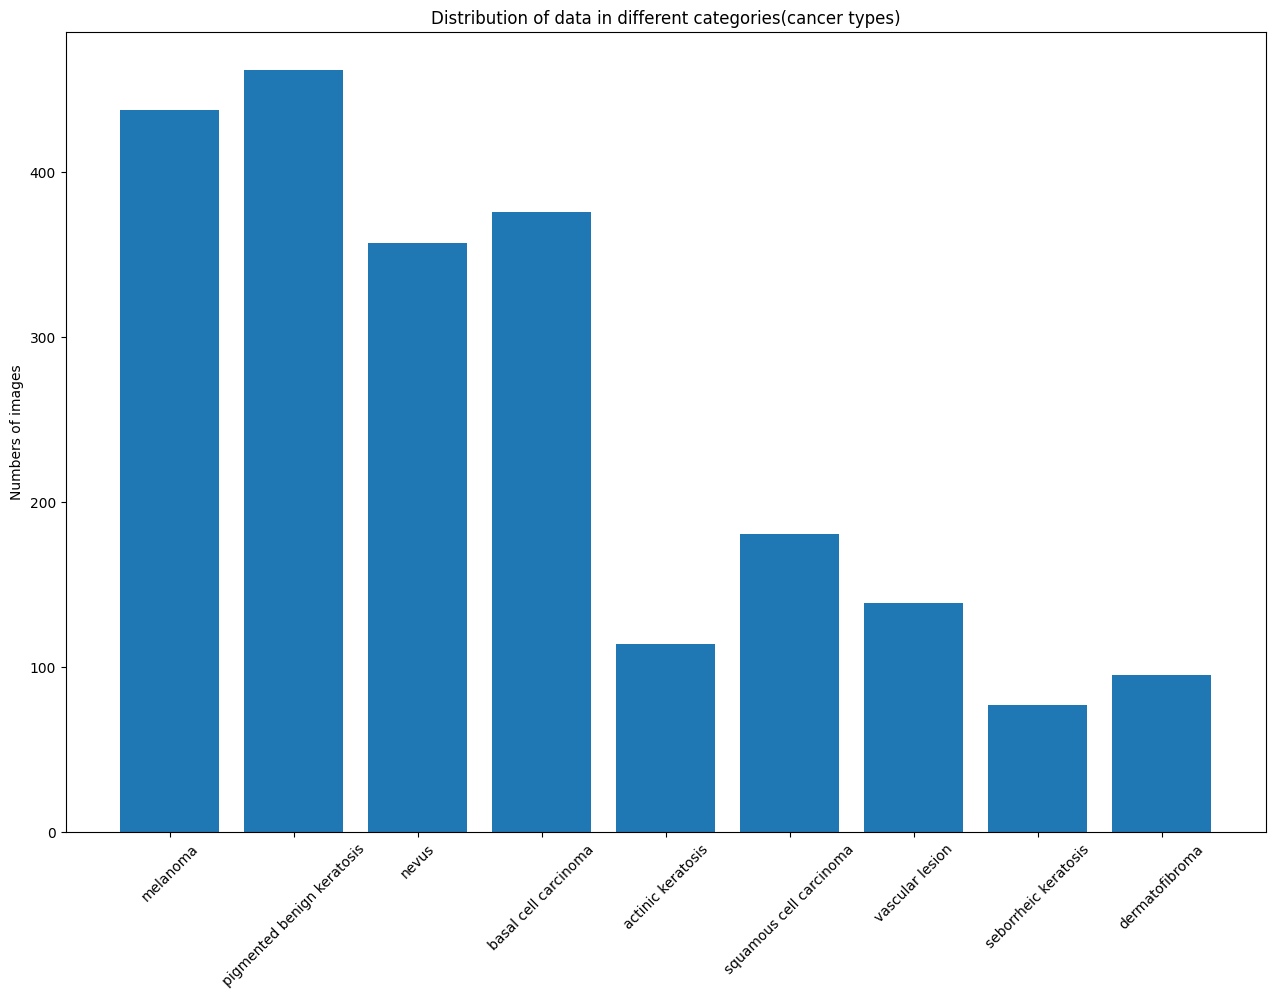

In [4]:
# Check the number of images under each category
x=[]
y=[]
#get file count in each directory
dirList = os.listdir(train_data_dir)
for i in range(len(dirList)):
  x.append(dirList[i])
  y.append(len(list(train_data_dir.glob(dirList[i]+'/*.jpg'))))


fig = plt.figure(figsize=(12,8))
ax = fig.add_axes([0,0,1,1])

ax.bar(x,y)
ax.set_ylabel('Numbers of images')
ax.set_title('Distribution of data in different categories(cancer types)')
plt.xticks(rotation=45)
plt.show()

In [5]:
# Above grapg shows that the number of images present against each category is different and varies greatly. 
# For now will, start using this dataset as is.

### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Dataset Creation

Define some parameters for the loader:

In [6]:
batch_size = 32
img_height = 180
img_width = 180
seed_val = 123
input_shape=(img_height,img_width,3)

Use 80% of the images for training, and 20% for validation.

In [7]:
# Read the train dataset(80%) using seed=123 using keras preprocessing image_dataset_from_directory utility
# resizing images to the size img_height=180*img_width=180, while loading the dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(train_data_dir,
                                                               seed=seed_val,
                                                               validation_split=0.2,
                                                               image_size=(img_height,img_width),
                                                               batch_size=batch_size,
                                                               color_mode='rgb',
                                                               subset='training')

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [8]:
# Read the validation dataset(20%) using seed=123 using keras preprocessing image_dataset_from_directory utility
# resizing images to the size img_height=180*img_width=180, while loading the dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(train_data_dir,
                                                               seed=seed_val,
                                                               validation_split=0.2,
                                                               image_size=(img_height,img_width),
                                                               batch_size=batch_size,
                                                               color_mode='rgb',
                                                               subset='validation')

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [9]:
# List out all the classes of skin cancer and store them in a list. 
# You can find the class names in the class_names attribute on these datasets. 
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Dataset Visualisation

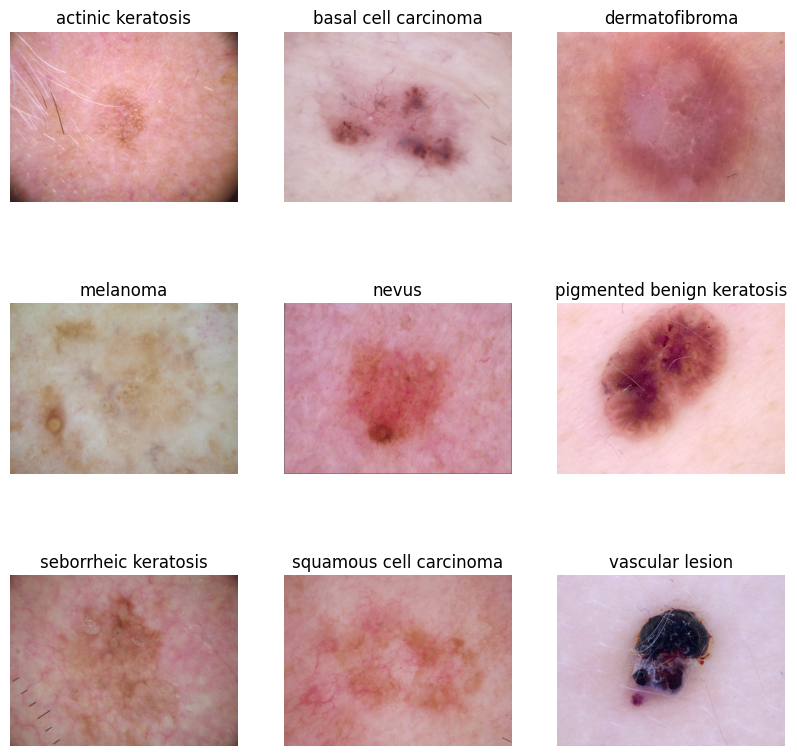

In [10]:
### visualize one image of all the nine classes present in the dataset
plt.figure(figsize=(10,10))
for i in range(len(class_names)): #loop through each class
  plt.subplot(3,3,i+1)
  image= plt.imread(str(list(train_data_dir.glob(class_names[i]+'/*.jpg'))[0])) #pick the first image in each directory
  plt.title(class_names[i])
  plt.imshow(image)
  plt.axis("off") #scale doesn't make any relevance here

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension, '3', refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [11]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
Create a CNN model, which can accurately detect 9 classes present in the dataset. Use "layers.experimental.preprocessing.Rescaling" to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

### Compile the model
Choose an appropirate optimiser and loss function for model training 

In [12]:
model = Sequential() # allows stack of layers where each layer has exactly one input tensor and one output tensor

# rescale to 0-255 range; which is the range of RGB values
model.add(layers.Rescaling(scale=1./255,input_shape=input_shape))

#1st convulation layer in the stack
model.add(layers.Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
model.add(layers.MaxPooling2D(pool_size=(2, 2))) #pooling 1/2
model.add(layers.Dropout(0.25))#dropping 25%

#2nd convulation layer in the stack
model.add(layers.Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Dropout(0.25)) #dropping 25%

#3rd convulation layer in the stack
model.add(layers.Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Dropout(0.25))#dropping 25%

# flatten takes all these and put it into a long flat vector. i.e put a fully connected layer
model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu')) # create fully connected layers
model.add(layers.Dropout(0.25))#dropping 25%

# softmax layer
model.add(layers.Dense(len(class_names), activation='softmax'))

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

In [13]:
# View the summary of all layers
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 89, 89, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 89, 89, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 87, 87, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 43, 43, 64)       0         
 2D)                                                    

### Train the model

In [14]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20


2023-07-16 20:59:57.477551: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [1792]
	 [[{{node Placeholder/_0}}]]
2023-07-16 20:59:57.478336: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [1792]
	 [[{{node Placeholder/_4}}]]


56/56 [==============================] - ETA: 0s - loss: 2.2556 - accuracy: 0.1886

2023-07-16 21:00:50.342749: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [447]
	 [[{{node Placeholder/_0}}]]
2023-07-16 21:00:50.343393: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [447]
	 [[{{node Placeholder/_4}}]]


56/56 [==============================] - 58s 833ms/step - loss: 2.2556 - accuracy: 0.1886 - val_loss: 2.0798 - val_accuracy: 0.1924
Epoch 2/20
56/56 [==============================] - 44s 792ms/step - loss: 2.0156 - accuracy: 0.2266 - val_loss: 1.9466 - val_accuracy: 0.3445
Epoch 3/20
56/56 [==============================] - 44s 795ms/step - loss: 1.8467 - accuracy: 0.3186 - val_loss: 1.7365 - val_accuracy: 0.3982
Epoch 4/20
56/56 [==============================] - 34s 601ms/step - loss: 1.7300 - accuracy: 0.3828 - val_loss: 1.7528 - val_accuracy: 0.3289
Epoch 5/20
56/56 [==============================] - 33s 595ms/step - loss: 1.6509 - accuracy: 0.4113 - val_loss: 1.5585 - val_accuracy: 0.4810
Epoch 6/20
56/56 [==============================] - 32s 574ms/step - loss: 1.6317 - accuracy: 0.4062 - val_loss: 1.5970 - val_accuracy: 0.4586
Epoch 7/20
56/56 [==============================] - 31s 556ms/step - loss: 1.5504 - accuracy: 0.4442 - val_loss: 1.5386 - val_accuracy: 0.4653
Epoch 8/20

### Visualizing training results

In [15]:
#Need to visualize the results at multiple places
#Hence creating a common method
def visualize_results(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(epochs)

    plt.figure(figsize=(8, 8))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.ylabel('accuracy')
    plt.xlabel(epochs_range)
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='lower left')
    plt.ylabel('loss')
    plt.xlabel(epochs_range)    
    plt.title('Training and Validation Loss')
    plt.axis("on")
    plt.show()

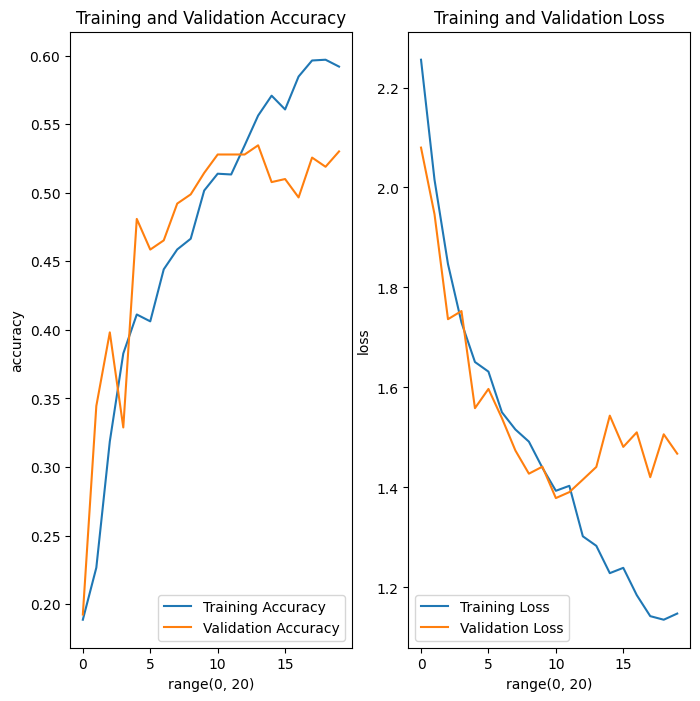

In [16]:
visualize_results(history)

In [17]:
t_loss, t_accuracy = model.evaluate(train_ds, verbose=1,)
v_loss, v_accuracy = model.evaluate(val_ds, verbose=1)

print("Training Accuracy: ", t_accuracy)
print("Validation Accuracy: ",v_accuracy)

print("Training Loss: ",t_loss)
print("Validation Loss", v_loss)

14/14 [==============================] - 2s 146ms/step - loss: 1.4675 - accuracy: 0.5302
Training Accuracy:  0.6768973469734192
Validation Accuracy:  0.5302013158798218
Training Loss:  1.028681993484497
Validation Loss 1.4675499200820923


### Observations

- Training accuracy is increasing with the range and the training loss is decreasing with range. In case of Validation accuracy its increasing with range, but after 8/9th epoch, its not increasing much, showing a some what flat trend at 50%. Similar trend is seen for validation loss as well.
- Accuracy overall is very low, performs poorly on the training data. Hence we can conclude that the model is underfitting
- Some of the reasons for underfitting are noise in data, high bias in model, not enough dataset, model is too simple etc
- In this case, looks like the model needs to be trained on more dataset

In [18]:
# Performing data augmentation to generate additional training data from existing images
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",input_shape=(img_height,img_width,3)),
    layers.RandomRotation(0.2, fill_mode='reflect'),
    layers.RandomZoom(height_factor=(0.2, 0.3), width_factor=(0.2, 0.3), fill_mode='reflect'),
  ]
)

2023-07-16 21:11:35.072908: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [1792]
	 [[{{node Placeholder/_4}}]]
2023-07-16 21:11:35.073394: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [1792]
	 [[{{node Placeholder/_4}}]]


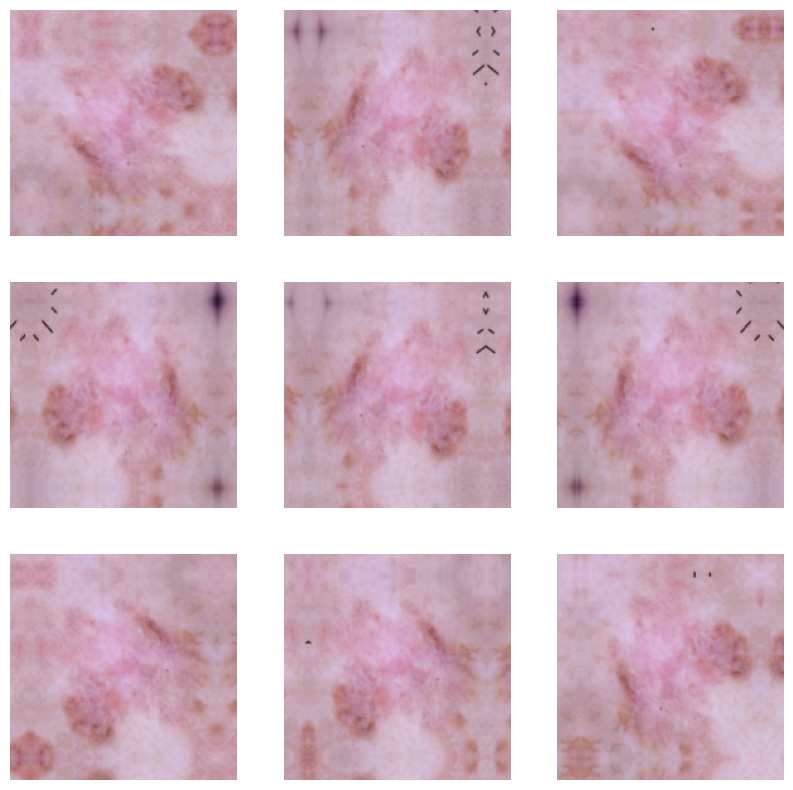

In [19]:
### visualize the augmented dataset
plt.figure(figsize=(10,10))
for images, _ in train_ds.take(1):
  for i in range(len(class_names)):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[1].numpy().astype("uint8"))
    plt.axis("off") #scale doesn't make any relevance here

### Create the model, compile and train the model


In [20]:
model = Sequential() # allows stack of layers where each layer has exactly one input tensor and one output tensor

# rescale to 0-255 range; which is the range of RGB values
model.add(layers.Rescaling(scale=1./255,input_shape=input_shape))

# adding the augmentation layer
model.add(data_augmentation)

#1st convulation layer in the stack
model.add(layers.Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
model.add(layers.MaxPooling2D(pool_size=(2, 2))) #pooling 1/2
model.add(layers.Dropout(0.25))#dropping 25%

#2nd convulation layer in the stack
model.add(layers.Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Dropout(0.25)) #dropping 25%

#3rd convulation layer in the stack
model.add(layers.Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Dropout(0.25))#dropping 25%

#4th convulation layer in the stack
model.add(layers.Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Dropout(0.25))#dropping 25%

# flatten takes all these and put it into a long flat vector. i.e put a fully connected layer
model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu')) # create fully connected layers
model.add(layers.Dropout(0.25))#dropping 25%

# softmax layer
model.add(layers.Dense(len(class_names), activation='softmax'))



### Compiling the model

In [21]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])
# View the summary of all layers
model.summary()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 sequential_1 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 89, 89, 32)       0         
 2D)                                                             
                                                                 
 dropout_4 (Dropout)         (None, 89, 89, 32)        0         
                                                                 
 conv2d_4 (Conv2D)           (None, 87, 87, 64)        18496     
                                                      

### Training the model

In [22]:
#train the model
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 37s 635ms/step - loss: 2.0742 - accuracy: 0.1936 - val_loss: 2.1096 - val_accuracy: 0.1924
Epoch 2/20
56/56 [==============================] - 36s 636ms/step - loss: 2.0501 - accuracy: 0.2081 - val_loss: 2.0634 - val_accuracy: 0.2796
Epoch 3/20
56/56 [==============================] - 35s 634ms/step - loss: 1.9724 - accuracy: 0.2372 - val_loss: 1.8812 - val_accuracy: 0.3132
Epoch 4/20
56/56 [==============================] - 36s 637ms/step - loss: 1.8642 - accuracy: 0.3064 - val_loss: 1.8330 - val_accuracy: 0.3065
Epoch 5/20
56/56 [==============================] - 35s 632ms/step - loss: 1.7929 - accuracy: 0.3376 - val_loss: 1.7134 - val_accuracy: 0.4049
Epoch 6/20
56/56 [==============================] - 36s 634ms/step - loss: 1.6905 - accuracy: 0.3839 - val_loss: 1.6132 - val_accuracy: 0.4139
Epoch 7/20
56/56 [==============================] - 36s 639ms/step - loss: 1.6131 - accuracy: 0.4191 - val_loss: 1.6981 - val_accuracy: 0.4295

### Visualizing the results

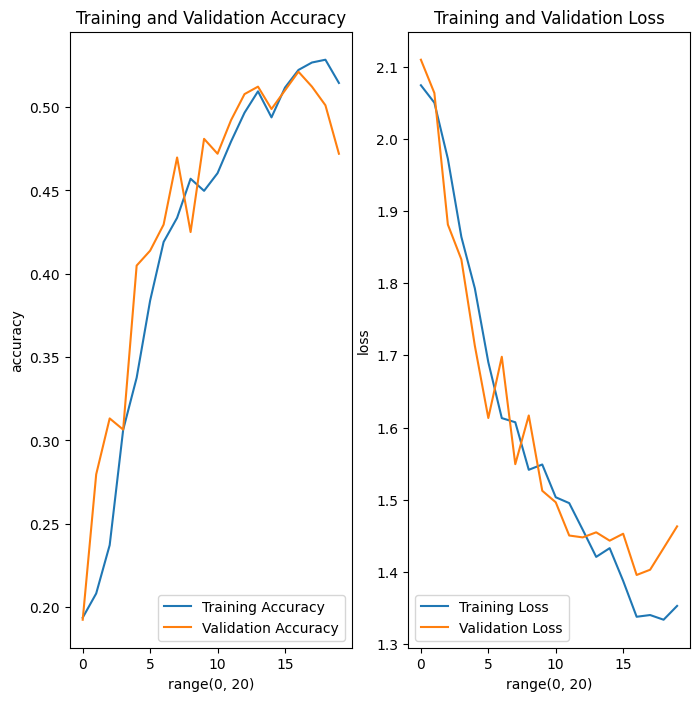

In [23]:
visualize_results(history)

In [24]:
t_loss, t_accuracy = model.evaluate(train_ds, verbose=1,)
v_loss, v_accuracy = model.evaluate(val_ds, verbose=1)

print("Training Accuracy: ", t_accuracy)
print("Validation Accuracy: ",v_accuracy)

print("Training Loss: ",t_loss)
print("Validation Loss", v_loss)

14/14 [==============================] - 2s 143ms/step - loss: 1.4631 - accuracy: 0.4720
Training Accuracy:  0.4827008843421936
Validation Accuracy:  0.47203579545021057
Training Loss:  1.380630373954773
Validation Loss 1.4630634784698486


### Observations
The pattern of accuracy improving over epoch is same even after the augmentation(though the overall accuracy has reduced compared to previous model). This holds true for train & validation accuracy. Loss in validation is reduced in this case. Another improvement noticed is that the gap between training & validation accuracy has reduced when compared to previous model.

Accuracy of the model is still not good - its around 50% only. This needs to be improved.

Lets have a look at the dataset and its distribution again

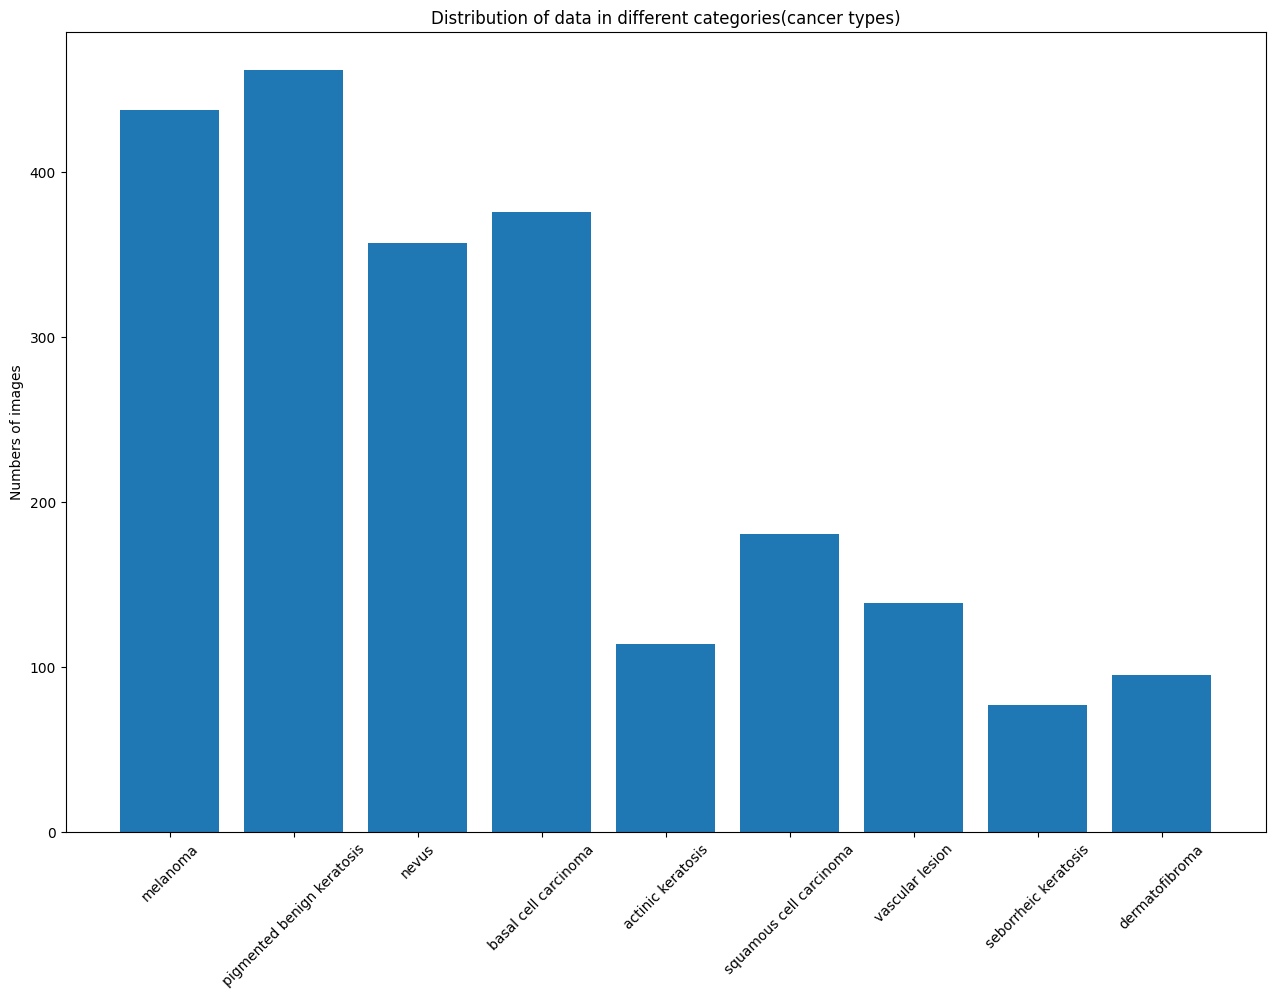

In [25]:
#Visualize the data distribution over different categories
x=[]
y=[]
#get file count in each directory
dirList = os.listdir(train_data_dir)
for i in range(len(dirList)):
  x.append(dirList[i])
  y.append(len(list(train_data_dir.glob(dirList[i]+'/*.jpg'))))


fig = plt.figure(figsize=(12,8))
ax = fig.add_axes([0,0,1,1])

ax.bar(x,y)
ax.set_ylabel('Numbers of images')
ax.set_title('Distribution of data in different categories(cancer types)')
plt.xticks(rotation=45)
plt.show()

#### Observations
    The number of images present for each category vary widely. This shows high imbalence in dataset.
- Which class has the least number of samples? 
     "seborrheic keratosis"
- Which classes dominate the data in terms proportionate number of samples?
    "pigmented benign keratosis"


#### Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [26]:
!pip install Augmentor

DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621
DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621

[notice] A new release of pip available: 22.3.1 -> 23.1.2
[notice] To update, run: python3.9 -m pip install --upgrade pip


To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [27]:
# Its assumed that all the input images are present in "Skin cancer ISIC The International Skin Imaging Collaboration" 
# folder. And this folder is present in one level above the directory as this source file present
# Also assumed that Train data set is present in Train folder and test in Test folder
path_to_training_dataset="../Skin cancer ISIC The International Skin Imaging Collaboration/Train/"
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to ../Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x1


Initialised with 376 image(s) found.
Output directory set to ../Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x161446DF0>: 100%|█|


Initialised with 95 image(s) found.
Output directory set to ../Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x1613E3F70>: 100%|█|


Initialised with 438 image(s) found.
Output directory set to ../Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=3072x2304 at 0


Initialised with 357 image(s) found.
Output directory set to ../Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=767x576 at 0x1611FFB50>: 100%|█|


Initialised with 462 image(s) found.
Output directory set to ../Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x1


Initialised with 77 image(s) found.
Output directory set to ../Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x16137B3A0>: 100%|█


Initialised with 181 image(s) found.
Output directory set to ../Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x16121E670>: 100%|█|


Initialised with 139 image(s) found.
Output directory set to ../Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x13B2C0370>: 100%|█|


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [28]:
#Checking the genereted files count
image_count_train = len(list(train_data_dir.glob('*/output/*.jpg')))
print(image_count_train)

4500


### Lets see the distribution of augmented data after adding new images to the original training data.

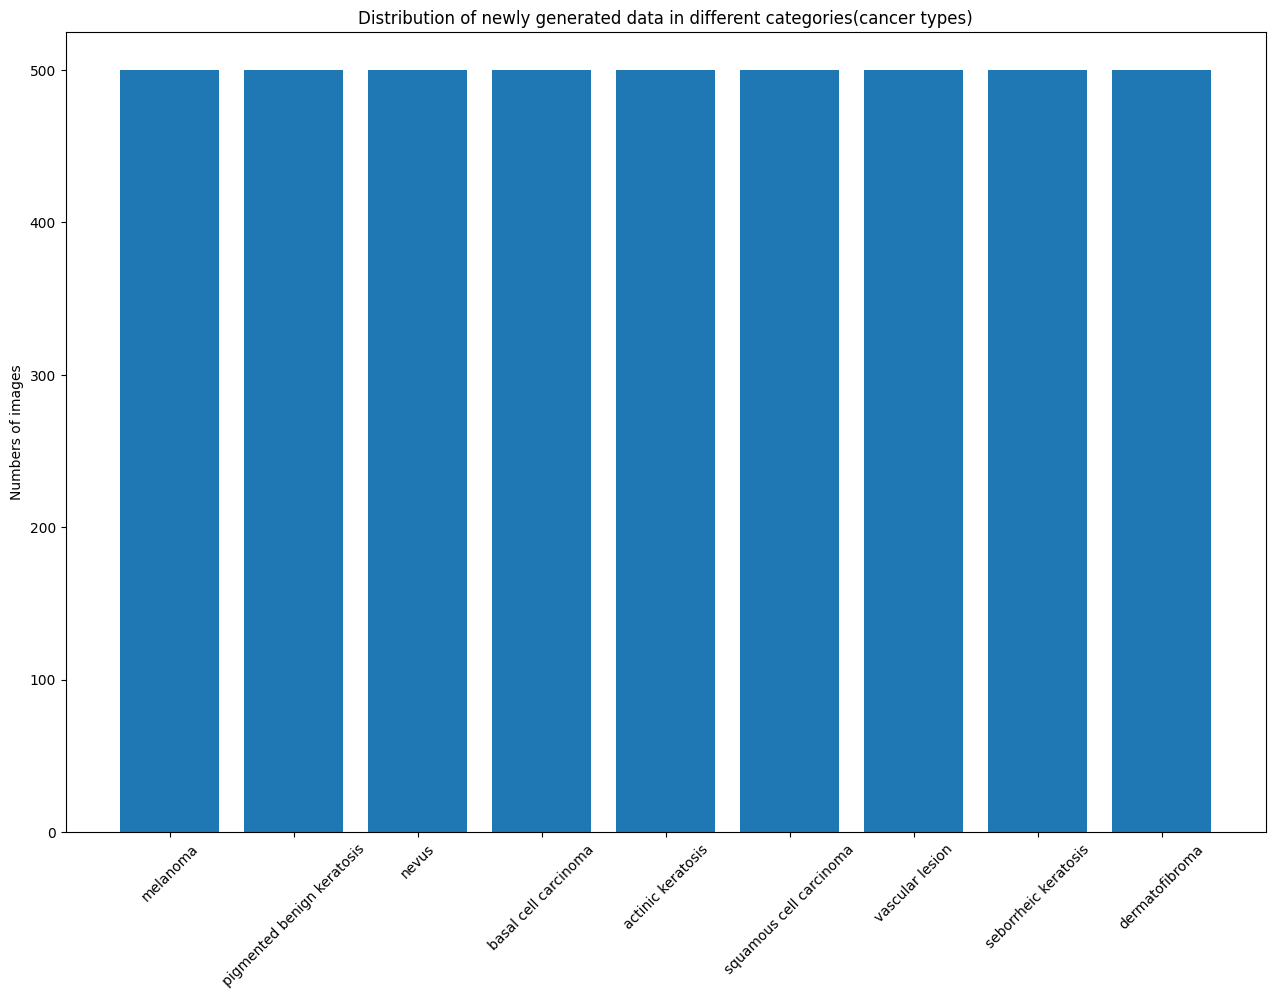

In [29]:
#Visualize the new data distribution over different categories
x=[]
y=[]
#get file count in each directory
dirList = os.listdir(train_data_dir)
for i in range(len(dirList)):
  x.append(dirList[i])
  y.append(len(list(train_data_dir.glob(dirList[i]+'/output/*.jpg'))))


fig = plt.figure(figsize=(12,8))
ax = fig.add_axes([0,0,1,1])

ax.bar(x,y)
ax.set_ylabel('Numbers of images')
ax.set_title('Distribution of newly generated data in different categories(cancer types)')
plt.xticks(rotation=45)
plt.show()

In [30]:
from glob import glob
path_list = [x for x in glob(os.path.join(train_data_dir, '*','output', '*.jpg'))]
path_list

['../Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0010537.jpg_27cf9c64-abe5-4be3-b6d9-a805449063a0.jpg',
 '../Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0009890.jpg_00e76713-2242-4109-b34f-b5dcd7214c1c.jpg',
 '../Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0010766.jpg_a909d548-af55-44d2-a39e-78e33e967133.jpg',
 '../Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0010470.jpg_16c27a1e-bcd5-4e16-988b-e49f25359b31.jpg',
 '../Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0000304.jpg_c0c6892a-b3cc-49d6-8c73-847d515363f6.jpg',
 '../Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0010610.jpg_867f2f5f-45cd-481c-9af9-5dc800bc93a8.jpg'

In [31]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(train_data_dir, '*','output', '*.jpg'))]
lesion_list_new

['melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',

In [32]:
# Look at the new dataset + old one
dirList = os.listdir(train_data_dir)
for i in range(len(dirList)):
  numOrg = len(list(train_data_dir.glob(dirList[i]+'/*.jpg')))
  numNew = len(list(train_data_dir.glob(dirList[i]+'/output/*.jpg')))
  print(dirList[i], " ", numOrg, '+', numNew, '=', numOrg+numNew)


melanoma   438 + 500 = 938
pigmented benign keratosis   462 + 500 = 962
nevus   357 + 500 = 857
basal cell carcinoma   376 + 500 = 876
actinic keratosis   114 + 500 = 614
squamous cell carcinoma   181 + 500 = 681
vascular lesion   139 + 500 = 639
seborrheic keratosis   77 + 500 = 577
dermatofibroma   95 + 500 = 595


So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### **Todo**: Train the model on the data created using Augmentor

In [33]:
batch_size = 32
img_height = 180
img_width = 180

#### Create a training dataset

In [34]:
# Read the train dataset(80%) using seed=123 using keras preprocessing image_dataset_from_directory utility
# resizing images to the size img_height=180*img_width=180, while loading the dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(train_data_dir,
                                                               seed=seed_val,
                                                               validation_split=0.2,
                                                               image_size=(img_height,img_width),
                                                               batch_size=batch_size,
                                                               color_mode='rgb',
                                                               subset='training')

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


#### Create a validation dataset

In [35]:
# Read the validation dataset(20%) using seed=123 using keras preprocessing image_dataset_from_directory utility
# resizing images to the size img_height=180*img_width=180, while loading the dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(train_data_dir,
                                                               seed=seed_val,
                                                               validation_split=0.2,
                                                               image_size=(img_height,img_width),
                                                               batch_size=batch_size,
                                                               color_mode='rgb',
                                                               subset='validation')
                                                               

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


#### Create your model (make sure to include normalization)

In [36]:
model = Sequential() # allows stack of layers where each layer has exactly one input tensor and one output tensor

# rescale to 0-255 range; which is the range of RGB values
model.add(layers.Rescaling(scale=1./255,input_shape=input_shape))

#1st convulation layer in the stack
model.add(layers.Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
model.add(layers.MaxPooling2D(pool_size=(2, 2))) #pooling 1/2
model.add(layers.Dropout(0.25))#dropping 25%

#2nd convulation layer in the stack
model.add(layers.Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Dropout(0.25)) #dropping 25%

#3rd convulation layer in the stack
model.add(layers.Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Dropout(0.25))#dropping 25%

#4th convulation layer in the stack
model.add(layers.Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Dropout(0.25))#dropping 25%

# flatten takes all these and put it into a long flat vector. i.e put a fully connected layer
model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu')) # create fully connected layers
model.add(layers.Dropout(0.25))#dropping 25%

# softmax layer
model.add(layers.Dense(len(class_names), activation='softmax'))

#### Compile your model (Choose optimizer and loss function appropriately)

In [37]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])
# View the summary of all layers
model.summary()


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_2 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_7 (Conv2D)           (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 89, 89, 32)       0         
 2D)                                                             
                                                                 
 dropout_9 (Dropout)         (None, 89, 89, 32)        0         
                                                                 
 conv2d_8 (Conv2D)           (None, 87, 87, 64)        18496     
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 43, 43, 64)       0         
 2D)                                                  

#### **Todo:**  Train your model

In [38]:
#train the model
epochs = 30
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30


2023-07-17 00:40:45.834523: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [5392]
	 [[{{node Placeholder/_0}}]]
2023-07-17 00:40:45.861792: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [5392]
	 [[{{node Placeholder/_4}}]]


169/169 [==============================] - ETA: 0s - loss: 1.9852 - accuracy: 0.2326

2023-07-17 01:02:46.760653: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [1347]
	 [[{{node Placeholder/_4}}]]
2023-07-17 01:02:46.761445: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [1347]
	 [[{{node Placeholder/_4}}]]


169/169 [==============================] - 1344s 2s/step - loss: 1.9852 - accuracy: 0.2326 - val_loss: 1.8079 - val_accuracy: 0.3534
Epoch 2/30
169/169 [==============================] - 1753s 10s/step - loss: 1.6457 - accuracy: 0.3709 - val_loss: 1.7569 - val_accuracy: 0.3452
Epoch 3/30
169/169 [==============================] - 2345s 14s/step - loss: 1.5161 - accuracy: 0.4156 - val_loss: 1.5029 - val_accuracy: 0.4313
Epoch 4/30
169/169 [==============================] - 2658s 16s/step - loss: 1.4648 - accuracy: 0.4260 - val_loss: 1.4214 - val_accuracy: 0.4395
Epoch 5/30
169/169 [==============================] - 2664s 16s/step - loss: 1.4055 - accuracy: 0.4484 - val_loss: 1.3961 - val_accuracy: 0.4551
Epoch 6/30
169/169 [==============================] - 2357s 14s/step - loss: 1.3408 - accuracy: 0.4748 - val_loss: 1.3934 - val_accuracy: 0.4647
Epoch 7/30
169/169 [==============================] - 2671s 16s/step - loss: 1.2811 - accuracy: 0.5070 - val_loss: 1.2793 - val_accuracy: 0.49

####  Visualize the model results

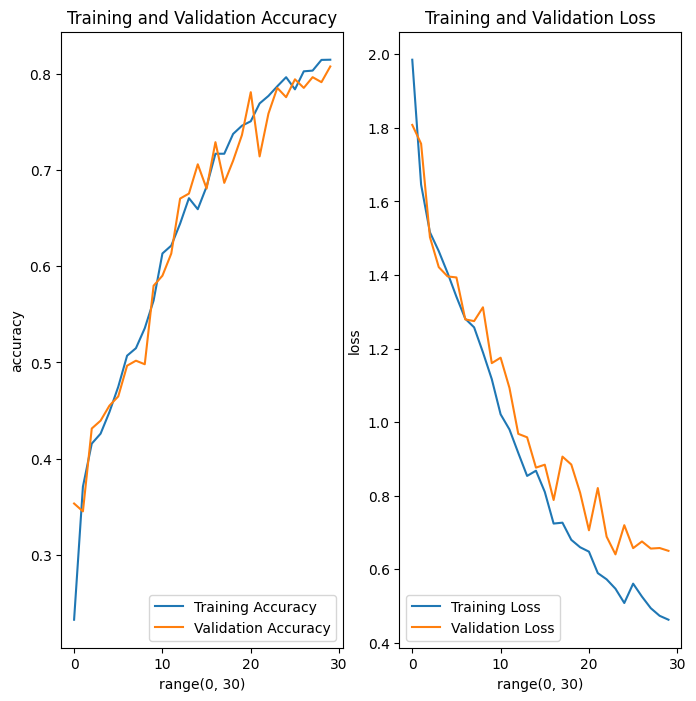

In [39]:
visualize_results(history)

In [40]:
t_loss, t_accuracy = model.evaluate(train_ds, verbose=1,)
v_loss, v_accuracy = model.evaluate(val_ds, verbose=1)

print("Training Accuracy: ", t_accuracy)
print("Validation Accuracy: ",v_accuracy)

print("Training Loss: ",t_loss)
print("Validation Loss", v_loss)

43/43 [==============================] - 11s 223ms/step - loss: 0.6502 - accuracy: 0.8077
Training Accuracy:  0.902633547782898
Validation Accuracy:  0.8077208399772644
Training Loss:  0.3024124801158905
Validation Loss 0.6502029895782471


### Observations:
- With increase in epochs, the accuracy of both validation & training increases.
- With increase in epochs, the training & validation loss decreases
- The difference between the training & validation accuracy has decreased a lot compared to other two models.
- More images in the dataset, rebalancing & more epochs helps to improve the performance of the model